In [6]:
import config
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import pandas as pd 

In [7]:
auth = SpotifyClientCredentials(
    client_id=config.SPOTIPY_CLIENT_ID,
    client_secret=config.SPOTIPY_CLIENT_SECRET
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  


In [10]:
def get_tracks_from_playlist(playlist_URI):
    offset = 0
    tracklist = []
    while True:
        response = sp.playlist_tracks(playlist_URI,
                                     offset=offset,
                                     fields='items.track.id,total',
                                     additional_types=['track'])
        tracks = response['items']
        for track in tracks:
            track_id = track['track']['id']
            tracklist.append(track_id)

        offset = offset + len(response['items'])
#         print(offset, "/", response['total'])

        if len(response['items']) == 0:
            break
            
    return tracklist

def create_augmented_df(playlist_URI, polarity=None):
    df = pd.DataFrame(columns=['track id'])
    df['track id'] = get_tracks_from_playlist(playlist_URI)
    if polarity:
        df['gt label'] = df['track id'].apply(lambda x: polarity)
    df['track name'] = df['track id'].apply(lambda x: sp.tracks([x])['tracks'][0]['name'])
    df['artist'] = df['track id'].apply(lambda x: sp.tracks([x])['tracks'][0]['artists'][0]['name'])
    df['danceability'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["danceability"])
    df['energy'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["energy"])
    df['key'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["key"])
    df['loudness'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["loudness"])
    df['mode'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["mode"])
    df['speechiness'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["speechiness"])
    df['acousticness'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["acousticness"])
    df['instrumentalness'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["instrumentalness"])
    df['liveness'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["liveness"])
    df['valence'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["valence"])
    df['tempo'] = df['track id'].apply(lambda x: sp.audio_features(x)[0]["tempo"])
    return df



In [11]:
# happy beats
df1 = create_augmented_df('spotify:playlist:37i9dQZF1DWSf2RDTDayIx', 1)
df1.head()

,track id,gt label,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2u6Jm2klS4yvAlbSHlxUwI,1,Alane,Robin Schulz,0.581,0.799,3,-6.660,1,0.1640,0.04190,0.000009,0.1100,0.662,124.002
1,2hCKAnd2BPo2VD65XZC3rH,1,Your Place or Mine,Wahlstedt,0.863,0.608,7,-2.996,1,0.1490,0.18000,0.000003,0.1140,0.389,126.053
2,73h6Ma5QhBFrshEN2CTevS,1,Someday,Kygo,0.612,0.686,7,-6.838,1,0.1200,0.17300,0.000000,0.1410,0.326,122.115
3,75rGONmoi48LLYBFaGiYsv,1,Both Of Us - Edit,Jayda G,0.735,0.710,11,-10.222,1,0.0766,0.00851,0.762000,0.0684,0.507,123.962
4,5zn3TuX5oBHrEv8R9KyLir,1,Ladida (My Heart Goes Boom) [feat. ILIRA],CRISPIE,0.682,0.812,0,-4.931,1,0.0307,0.11100,0.000021,0.1370,0.455,126.040


In [12]:
# life sucks
df2 = create_augmented_df('spotify:playlist:37i9dQZF1DX3YSRoSdA634', 0)
df2.head()

,track id,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4CxFN5zON70B3VOPBYbd6P,you were good to me,Jeremy Zucker,0.561,0.0848,2,-15.099,1,0.0404,0.913,0.000026,0.1120,0.206,102.128
1,0VhgEqMTNZwYL1ARDLLNCX,Can I Be Him,James Arthur,0.696,0.5430,11,-6.164,1,0.0489,0.308,0.000000,0.0939,0.479,107.969
2,4IhAzl3KH8P7KFJ5KfBnvy,Pearl in Sandbox,Júníus Meyvant,0.595,0.0626,8,-21.945,1,0.0452,0.917,0.076500,0.0987,0.259,126.337
3,2TIlqbIneP0ZY1O0EzYLlc,Someone You Loved,Lewis Capaldi,0.501,0.4050,1,-5.679,1,0.0319,0.751,0.000000,0.1050,0.446,109.891
4,6ynqpQIQ1kGtJILbxnCIQ8,Tourist,Axel Flóvent,0.455,0.2090,6,-12.150,0,0.0265,0.741,0.001940,0.1130,0.109,89.909


In [ ]:
df_test = pd.concat([df1, df2])
df_test

In [ ]:
df_test.to_csv('./data/test.csv', index=False)

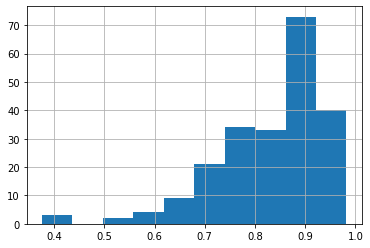

In [18]:
df1['energy'].hist()

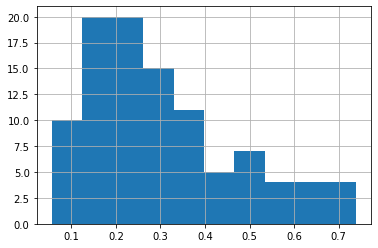

In [19]:
df2['energy'].hist()